Importing Packages

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
import seaborn as sns
import sklearn as sk


In [26]:
import kagglehub
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

#download dataset from kagglehub
path = kagglehub.dataset_download("prasad22/healthcare-dataset")

print("Path to dataset folder:", path)
csv_file_path = os.path.join(path, "healthcare_dataset.csv")

# Read the CSV
data = pd.read_csv(csv_file_path)
data_copy = data.copy()
data.head()

Using Colab cache for faster access to the 'healthcare-dataset' dataset.
Path to dataset folder: /kaggle/input/healthcare-dataset


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


# Exploring the Data


What is your outcome variable(s)?


*   Predicted Billing Amount





How well does it measure the outcome you are interested in?:
Our outcome variable is being used to help fit the model's we will be evaluating for algorithmic bias. Therefore, we are not directly predicting our outcome variable rather we are using it to see if the model will predict bias outcomes by evaluating model statistics



**How does it relate to your expectations?**  
We are interested in evaluating model performance to determine potential bias or discrepancies. Therefore, we focus on test statistics such as $R^2$, $\text{Adj. } R^2$, etc. The outcome variable we choose is only needed for creating the models that will be evaluated for bias.



# Data Preparation and Cleaning


One of the advantages to using a sythetic data set is that our data table is already in good condition from the beginning, so the amount of cleaning necessary was minimal. We first reformatted all the patient names to Title Case. Next, we iterated through the dataset to remove any rows with duplicate patient names, as well as any rows with missing values (as our data was already well orginized, no rows were actually removed, and this served as a sanity check). We elected to exclude two observations from our dataset, those being "Doctor" and "Room Number". These were removed as they served no purpose whatsoever to the outcomes we are seeking to measure, and by taking them into account, our models may actually have been less accurate, as they would be bogged down with irrelelvant data. We created one new variable, "Race". This observation is critical for examining potential bias related to our outcome variable, Billing Amount. We created this column by first collecting US Census data regarding the demographic makup of the United States, then converting those percentages into probabilities. Next, we simply randomly generated each item in the Race column based on those probabilities. Lastly, we set a seed, so that once generated for the first time, the Race column would remain static in the future.



**Variable Addition**

In [27]:
#Creating Biased Dataset
import math as math
#Making Race Variables
np.random.seed(1)  #For Reproducability
data['Race'] = np.random.rand(len(data))

def probabilities(prob):
    if prob <= 0.59:
        return 'White'
    elif prob <= 0.72:
        return 'African American'
    elif prob <= 0.91:
        return 'Hispanic'
    elif prob <= 0.97:
        return 'Asian'
    else:
        return 'Multiracial'

data['Race'] = data['Race'].apply(probabilities)

#Checking Proportions
print('White:',sum(data['Race'] == 'White')/len(data))
print('African American:',sum(data['Race'] == 'African American')/len(data))
print('Hispanic:',sum(data['Race'] == 'Hispanic')/len(data))
print('Asian:',sum(data['Race'] == 'Asian')/len(data))
print('Multiracial:',sum(data['Race'] == 'Multiracial')/len(data))


total_length = len(data)
data.head()

White: 0.5904144144144144
African American: 0.12994594594594594
Hispanic: 0.1898918918918919
Asian: 0.06009009009009009
Multiracial: 0.029657657657657658


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,Race
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal,White
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive,Hispanic
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal,White
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal,White
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal,White


**Data Cleaning**

In [28]:
#Data Cleaning

#Convert Names to title case
data['Name'] = data['Name'].str.title()
print(f'Data Length: {total_length}')

#drop non unique data
ata = data.drop_duplicates(subset=['Name'])
count_dupliicates = total_length - len(data)
total_length = len(data)
print(f'{count_dupliicates} non unique rows were dropped')

#Drop NA/NaNs
data = data.dropna()
count_NA = total_length - len(data)

print(f'{count_NA}  rows with invalid entry were dropped')


#drop meaningless columns (room numbers, and doctor)
data = data.drop(columns=['Room Number', 'Doctor'])
data


Data Length: 55500
0 non unique rows were dropped
0  rows with invalid entry were dropped


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Hospital,Insurance Provider,Billing Amount,Admission Type,Discharge Date,Medication,Test Results,Race
0,Bobby Jackson,30,Male,B-,Cancer,2024-01-31,Sons and Miller,Blue Cross,18856.281306,Urgent,2024-02-02,Paracetamol,Normal,White
1,Leslie Terry,62,Male,A+,Obesity,2019-08-20,Kim Inc,Medicare,33643.327287,Emergency,2019-08-26,Ibuprofen,Inconclusive,Hispanic
2,Danny Smith,76,Female,A-,Obesity,2022-09-22,Cook PLC,Aetna,27955.096079,Emergency,2022-10-07,Aspirin,Normal,White
3,Andrew Watts,28,Female,O+,Diabetes,2020-11-18,"Hernandez Rogers and Vang,",Medicare,37909.782410,Elective,2020-12-18,Ibuprofen,Abnormal,White
4,Adrienne Bell,43,Female,AB+,Cancer,2022-09-19,White-White,Aetna,14238.317814,Urgent,2022-10-09,Penicillin,Abnormal,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55495,Elizabeth Jackson,42,Female,O+,Asthma,2020-08-16,Jones-Thompson,Blue Cross,2650.714952,Elective,2020-09-15,Penicillin,Abnormal,African American
55496,Kyle Perez,61,Female,AB-,Obesity,2020-01-23,Tucker-Moyer,Cigna,31457.797307,Elective,2020-02-01,Aspirin,Normal,White
55497,Heather Wang,38,Female,B+,Hypertension,2020-07-13,"and Mahoney Johnson Vasquez,",UnitedHealthcare,27620.764717,Urgent,2020-08-10,Ibuprofen,Abnormal,Hispanic
55498,Jennifer Jones,43,Male,O-,Arthritis,2019-05-25,"Jackson Todd and Castro,",Medicare,32451.092358,Elective,2019-05-31,Ibuprofen,Abnormal,Hispanic


# Biased Datasets

### Representation Bias
To show Bias in our dataset,we will manipulate the Race variable to show unequal proportions of males and females which will simulate Representation Bias.

In [29]:
import random
#Creating a dataset w/ 70% males and 30% females
gender_bias_data = data.copy()

#Our bias data will only contain 10,000 entries(7000 males,3000 females)
n_male = list(data.index[data['Gender'] == 'Male'])
maleIDs = random.sample(n_male,7000)

n_females = list(data.index[data['Gender'] == 'Female'])
femaleIDs = random.sample(n_females,3000)

genders = maleIDs + femaleIDs

gender_bias_data = gender_bias_data.iloc[genders,:]
print(sum(gender_bias_data['Gender'] == 'Male'))
print(sum(gender_bias_data['Gender'] == 'Female'))

gender_bias_data.head(10)

7000
3000


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Hospital,Insurance Provider,Billing Amount,Admission Type,Discharge Date,Medication,Test Results,Race
25718,Mario Vasquez,46,Male,AB+,Asthma,2023-09-05,Forbes-Martinez,Blue Cross,16895.680125,Urgent,2023-09-07,Aspirin,Normal,White
48801,Gina White,44,Male,AB-,Arthritis,2020-06-10,Reed-Nelson,Cigna,49318.586783,Elective,2020-07-07,Ibuprofen,Normal,White
32550,Jessica Fisher,69,Male,A-,Obesity,2020-07-05,Moon-Gallagher,UnitedHealthcare,3374.955732,Emergency,2020-07-08,Penicillin,Normal,Hispanic
53397,Sean Barton,25,Male,B+,Arthritis,2019-06-24,Taylor-Hart,Medicare,8760.173500,Urgent,2019-07-15,Aspirin,Inconclusive,White
32621,David Williams,77,Male,AB-,Diabetes,2023-11-22,"Roberts and Santiago Jackson,",Medicare,9480.430218,Elective,2023-12-08,Paracetamol,Abnormal,White
31177,Jo Mason Md,44,Male,B+,Hypertension,2020-05-04,"Anderson Morris and Ramirez,",UnitedHealthcare,42499.623777,Elective,2020-05-12,Lipitor,Inconclusive,White
42535,Christopher Smith,38,Male,A-,Arthritis,2021-11-17,"and Gordon, Hamilton Hunter",Medicare,20077.273906,Urgent,2021-11-23,Ibuprofen,Abnormal,White
4634,Linda Jones,82,Male,A+,Arthritis,2023-09-01,PLC Miller,Medicare,28452.747744,Urgent,2023-09-23,Lipitor,Inconclusive,Hispanic
37513,Robert Morris,30,Male,A-,Arthritis,2022-04-01,Todd-Jones,Cigna,24687.763671,Emergency,2022-04-23,Penicillin,Normal,Multiracial
9571,John Lopez,85,Male,AB+,Hypertension,2023-11-26,PLC Roberts,UnitedHealthcare,18811.313856,Elective,2023-11-27,Ibuprofen,Inconclusive,African American


# Data Visualization


Billing Amount(Outcome Variable) Distribution

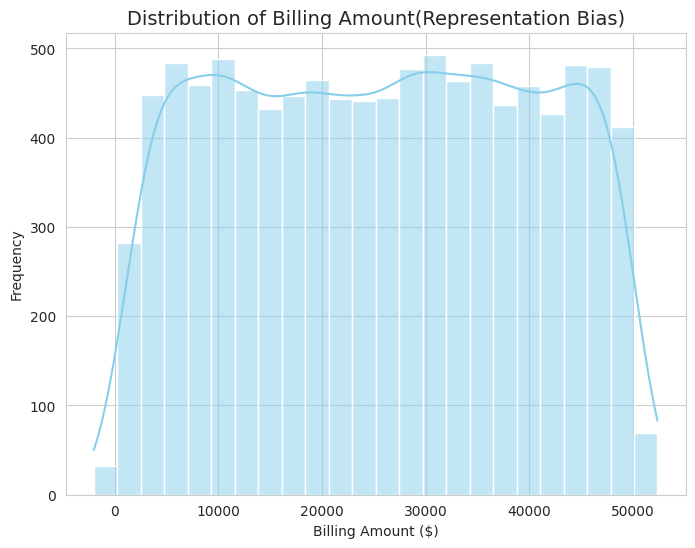

--- Alt Text for the Plot ---
A histogram of billing amounts from the gender-biased dataset. Billing amounts range from approximately $0 to $50,000. The distribution is plateau shaped


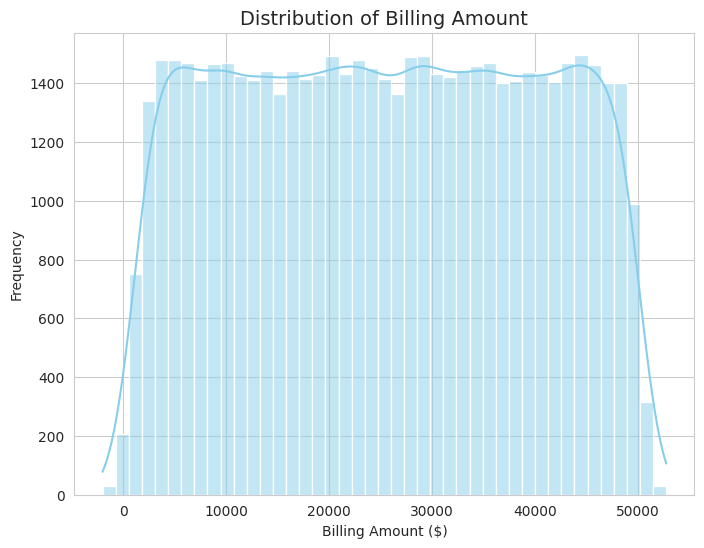

--- Alt Text for the Plot ---
A histogram of billing amounts from the original dataset. Billing amounts range from approximately $0 to $50,000. The distribution is plateau shaped


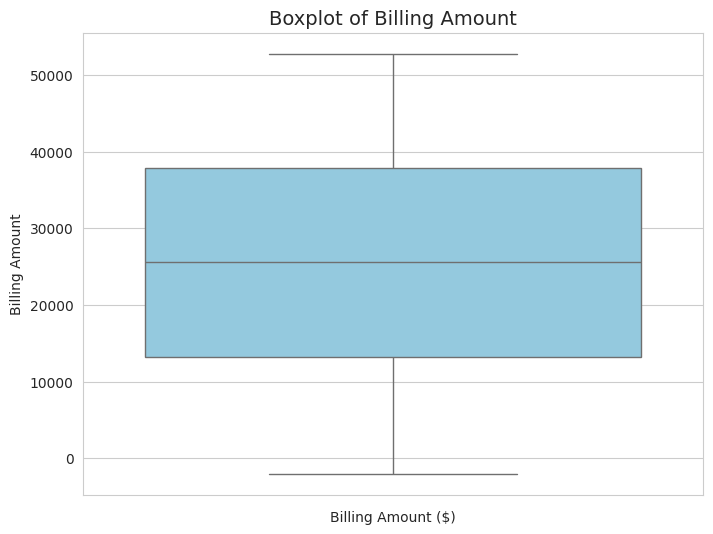

--- Alt Text for the Plot ---
A Box Plot of the billing amounts from the biased dataset, with a median of around $25,000 and an interquartile range of 20,000


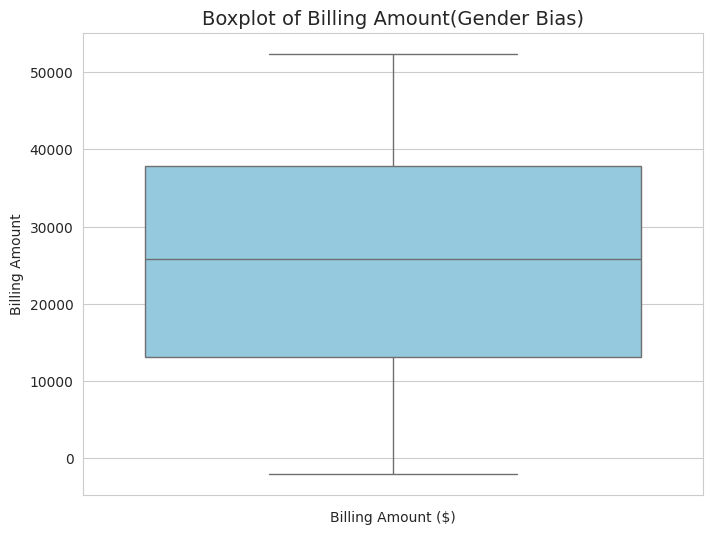

--- Alt Text for the Plot ---
A Box Plot of the billing amounts from the original dataset, with a median of around $25,000 and an interquartile range of 20,000


In [30]:
 # Set plot style
sns.set_style("whitegrid")

# Create the histogram(Biased Data)
plt.figure(figsize=(8, 6))
sns.histplot(gender_bias_data['Billing Amount'], kde=True, color='skyblue')
plt.title('Distribution of Billing Amount(Representation Bias)', fontsize=14)
plt.xlabel('Billing Amount ($)')
plt.ylabel('Frequency')
plt.show()
print("--- Alt Text for the Plot ---")
print("A histogram of billing amounts from the gender-biased dataset. Billing amounts range from approximately $0 to $50,000. The distribution is plateau shaped")

# Create the histogram(Full Data)
plt.figure(figsize=(8, 6))
sns.histplot(data['Billing Amount'], kde=True, color='skyblue')
plt.title('Distribution of Billing Amount', fontsize=14)
plt.xlabel('Billing Amount ($)')
plt.ylabel('Frequency')
plt.show()
print("--- Alt Text for the Plot ---")
print("A histogram of billing amounts from the original dataset. Billing amounts range from approximately $0 to $50,000. The distribution is plateau shaped")


#Create the Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(data['Billing Amount'],color = 'skyblue')
plt.title("Boxplot of Billing Amount",fontsize = 14)
plt.xlabel("Billing Amount ($)")
plt.show()
print("--- Alt Text for the Plot ---")
print("A Box Plot of the billing amounts from the biased dataset, with a median of around $25,000 and an interquartile range of 20,000")


#Create the Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(gender_bias_data['Billing Amount'],color = 'skyblue')
plt.title("Boxplot of Billing Amount(Gender Bias)",fontsize = 14)
plt.xlabel("Billing Amount ($)")
plt.show()
print("--- Alt Text for the Plot ---")
print("A Box Plot of the billing amounts from the original dataset, with a median of around $25,000 and an interquartile range of 20,000")



Race/Ethinicity Distribution

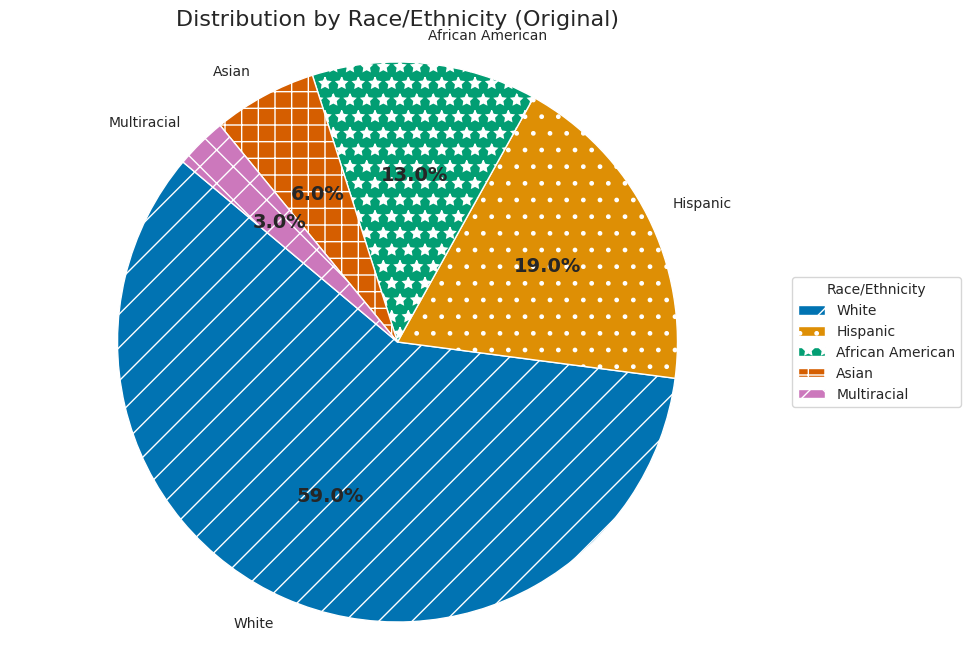

--- Alt Text for the Plot ---
A Pie Chart of the race distribution of our dataset, showing the following breakdown: White at 59.0%, Black at 13.0%, Hispanic at 19.0%, Asian at 6.0%,  and Other at 3.0%.


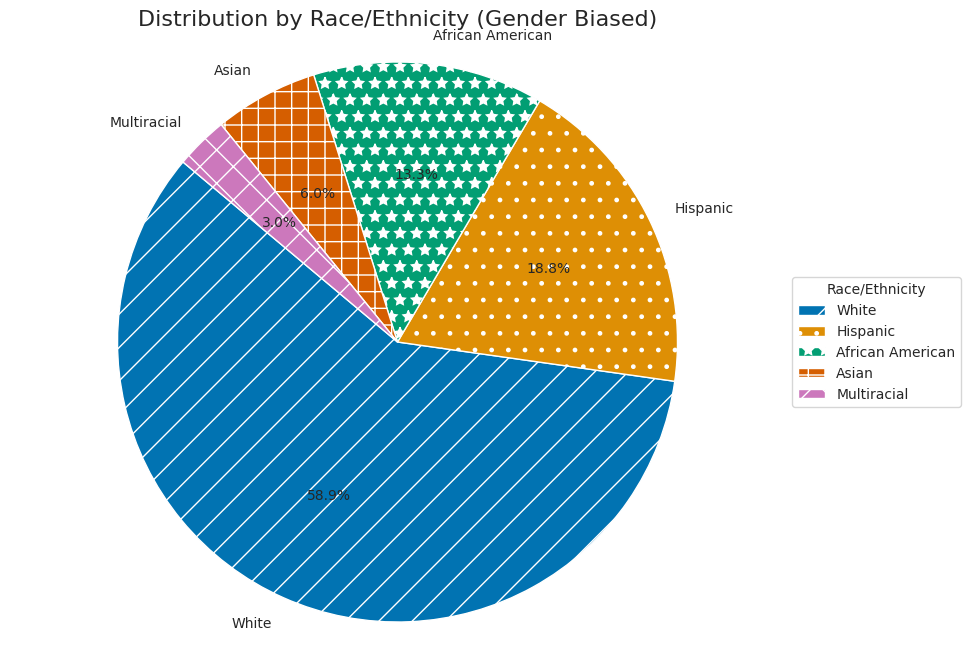

--- Alt Text for the Plot ---
A Pie Chart of the race distribution of our dataset, showing the following breakdown: White at 58.5%, Black at 13.5%, Hispanic at 18.8%, Asian at 5.9%,  and Other at 3.4%.


In [31]:
race_counts = data['Race'].value_counts()
race_counts_gender_bias = gender_bias_data['Race'].value_counts()

#Accessibility Features
colors = sns.color_palette('colorblind', n_colors=len(race_counts))
hatches = ['/', '.', '*', '+', 'x']

# Plot Chart (Orinigal)
fig1, ax1 = plt.subplots(figsize=(10, 8))
wedges,texts,autotexts = ax1.pie(race_counts,labels=race_counts.index,autopct='%1.1f%%',startangle=140,colors=colors) #type:ignore
#enlarge label font size
plt.setp(autotexts, size=14, weight="bold")

for i, wedge in enumerate(wedges):
    wedge.set_hatch(hatches[i])
ax1.set_title('Distribution by Race/Ethnicity (Original)', fontsize=16)
ax1.axis('equal')
ax1.legend(wedges, race_counts.index, title="Race/Ethnicity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A Pie Chart of the race distribution of our dataset, showing the following breakdown: White at 59.0%, Black at 13.0%, Hispanic at 19.0%, Asian at 6.0%,  and Other at 3.0%.")



# Plot Chart (Gender Biased)
fig2, ax2 = plt.subplots(figsize=(10, 8))
wedges2, texts2, autotexts2 = ax2.pie(race_counts_gender_bias,labels=race_counts_gender_bias.index,autopct='%1.1f%%',startangle=140,colors=colors) #type:ignore

#enlarge label font size
plt.setp(autotexts, size=14, weight="bold")
for i, wedge in enumerate(wedges2):
    wedge.set_hatch(hatches[i])
ax2.set_title('Distribution by Race/Ethnicity (Gender Biased)', fontsize=16)
ax2.axis('equal')
ax2.legend(wedges2, race_counts_gender_bias.index, title="Race/Ethnicity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A Pie Chart of the race distribution of our dataset, showing the following breakdown: White at 58.5%, Black at 13.5%, Hispanic at 18.8%, Asian at 5.9%,  and Other at 3.4%.")


Distribution by Condition

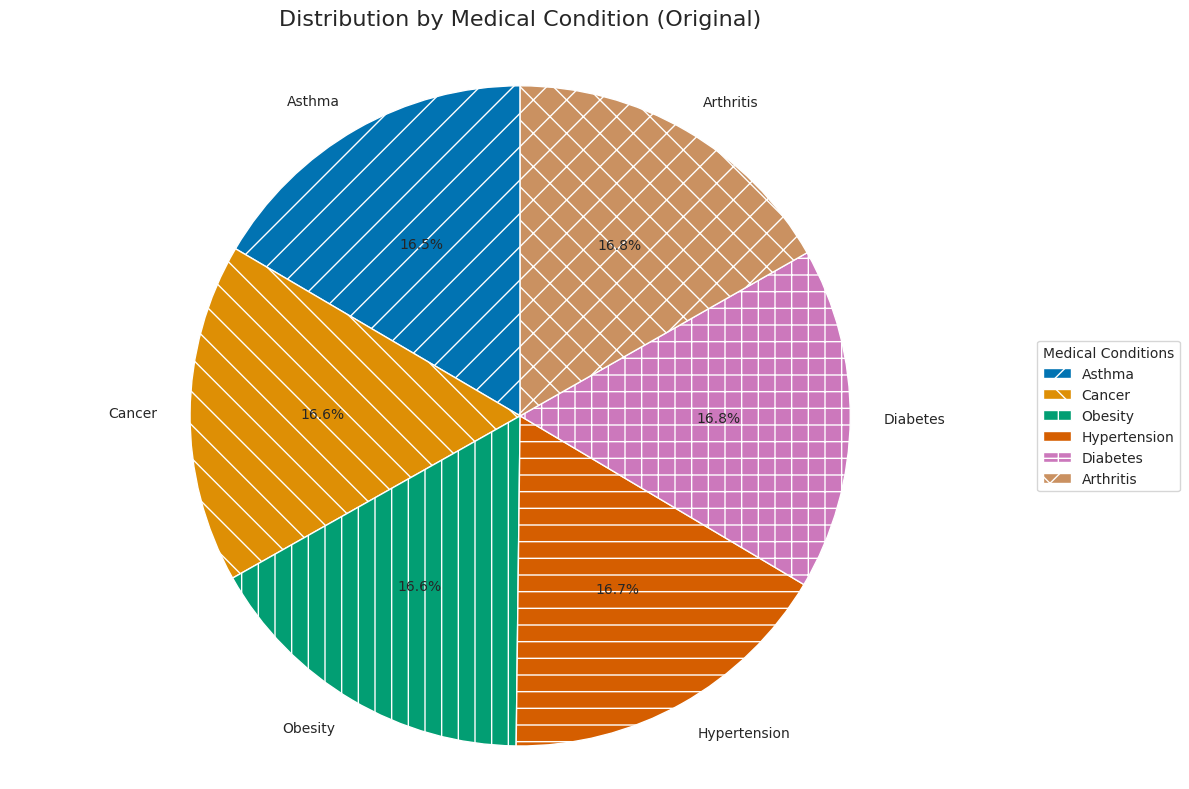

--- Alt Text for the Plot ---
A pie chart of the medical condition distribution in the dataset. 
 The six conditions listed—Arthritis, Diabetes, Asthma, Hypertension, Obesity, and Cancer—are evenly distributed, 
 with each accounting for approximately 16.7% of the total


In [32]:
condition_counts = data['Medical Condition'].value_counts(normalize=True) * 100
condition_counts = condition_counts.sort_values()

# Accessibility Features
patterns = ['/', '\\', '|', '-', '+', 'x']
colors = sns.color_palette('colorblind', n_colors=len(condition_counts))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

wedges,texts,autotexts = ax.pie(condition_counts,autopct='%1.1f%%',startangle=90,colors=colors,labels=condition_counts.index) #type:ignore

# Apply a different pattern to each wedge
for i, wedge in enumerate(wedges):
    wedge.set_hatch(patterns[i % len(patterns)])

# Formatting and Labels
ax.set_title('Distribution by Medical Condition (Original)', fontsize=16, pad=20)
ax.axis('equal')
ax.legend(wedges, condition_counts.index,
          title="Medical Conditions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart of the medical condition distribution in the dataset. \n The six conditions listed—Arthritis, Diabetes, Asthma, Hypertension, Obesity, and Cancer—are evenly distributed, \n with each accounting for approximately 16.7% of the total")


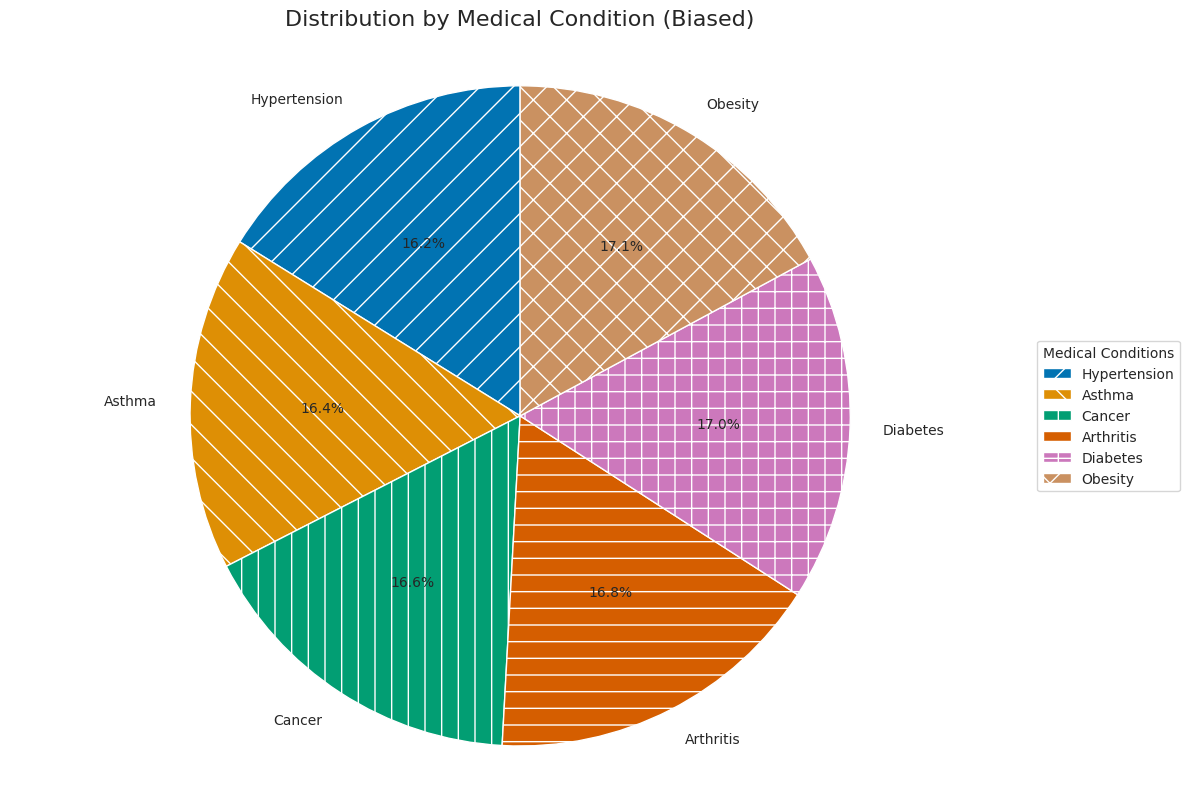

--- Alt Text for the Plot ---
A pie chart of the medical condition distribution in the dataset. 
 The six conditions listed—Arthritis, Diabetes, Asthma, Hypertension, Obesity, and Cancer—are evenly distributed, 
 with each accounting for approximately 16.7% of the total


In [33]:
condition_counts = gender_bias_data['Medical Condition'].value_counts(normalize=True) * 100
condition_counts = condition_counts.sort_values()

# Accessibility Features
patterns = ['/', '\\', '|', '-', '+', 'x']
colors = sns.color_palette('colorblind', n_colors=len(condition_counts))

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

wedges, texts, autotexts = ax.pie(condition_counts,autopct='%1.1f%%',startangle=90,colors=colors,labels=condition_counts.index)#type:ignore

# Apply a different pattern to each wedge
for i, wedge in enumerate(wedges):
    wedge.set_hatch(patterns[i % len(patterns)])

# Formatting and Labels
ax.set_title('Distribution by Medical Condition (Biased)', fontsize=16, pad=20)
ax.axis('equal')
ax.legend(wedges, condition_counts.index,
          title="Medical Conditions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart of the medical condition distribution in the dataset. \n The six conditions listed—Arthritis, Diabetes, Asthma, Hypertension, Obesity, and Cancer—are evenly distributed, \n with each accounting for approximately 16.7% of the total")


Distribution by Age

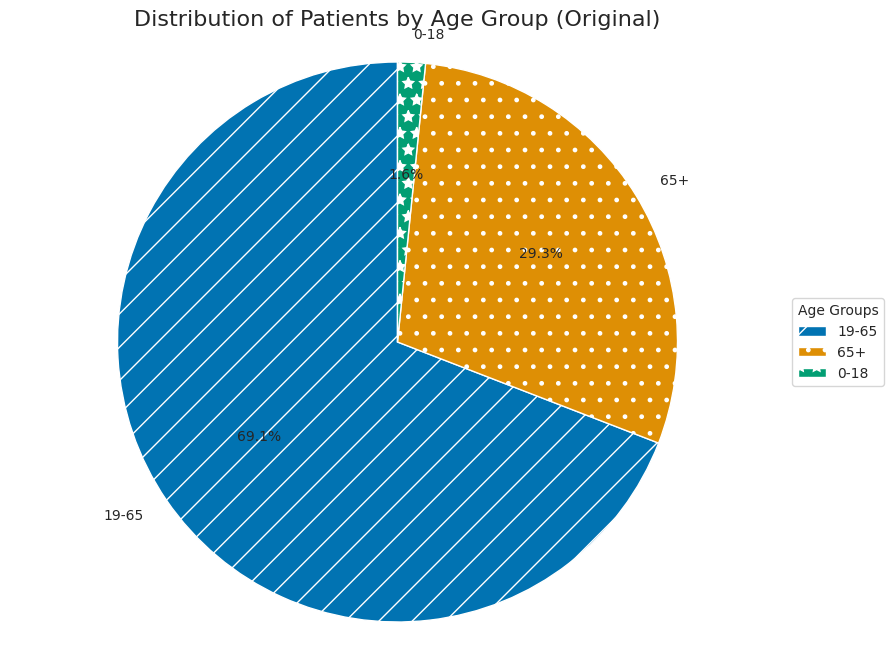

--- Alt Text for the Plot ---
A pie chart showing the age distribution of the dataset, broken down into three groups. 
 The distribution is as follows: the 18-65 age group comprises 69.1%, 
 the 65+ age group comprises 29.3%, and the 0-18 age group comprises 1.6%.


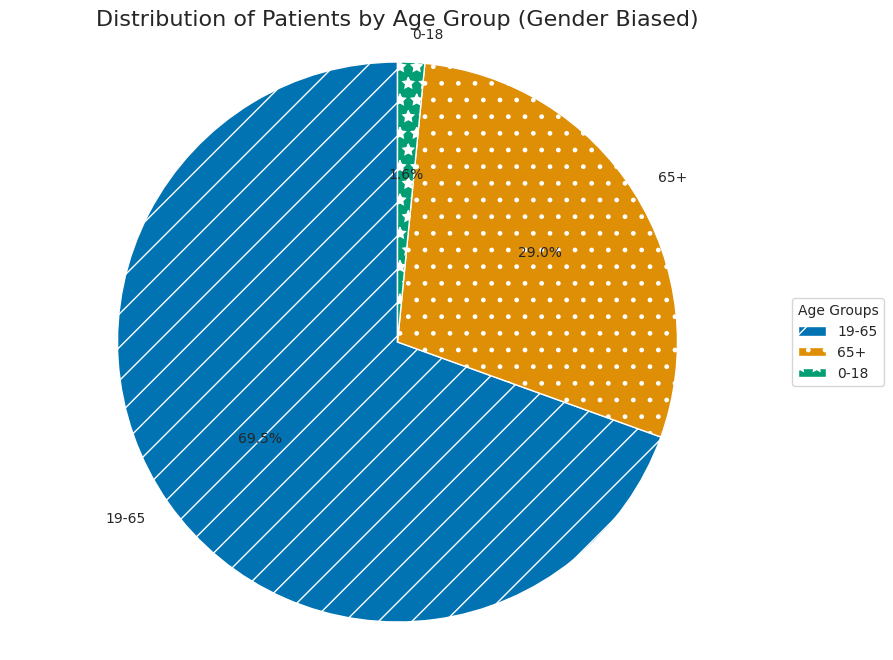

--- Alt Text for the Plot ---
A pie chart showing the age distribution of the dataset, broken down into three groups. 
 The distribution is as follows: the 18-65 age group comprises 68.9%, 
 the 65+ age group comprises 29.4%, and the 0-18 age group comprises 1.7%.


In [34]:
age_bins = [0, 18, 65, 999]
age_labels = ['0-18', '19-65', '65+']
data['Age Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=True)
gender_bias_data['Age Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=True)


age_group_counts = data['Age Group'].value_counts()
age_group_counts_biased = gender_bias_data['Age Group'].value_counts()


# Accessibility Features
colors = sns.color_palette('colorblind', n_colors=3)
hatches = ['/', '.', '*']

# Plot (Original Data)
fig1, ax1 = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax1.pie(age_group_counts,labels=age_group_counts.index,autopct='%1.1f%%',startangle=90,colors=colors)#type:ignore

# Apply patterns
for i, wedge in enumerate(wedges):
    wedge.set_hatch(hatches[i])

ax1.set_title('Distribution of Patients by Age Group (Original)', fontsize=16)
ax1.axis('equal')
ax1.legend(wedges, age_group_counts.index, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart showing the age distribution of the dataset, broken down into three groups. \n The distribution is as follows: the 18-65 age group comprises 69.1%, \n the 65+ age group comprises 29.3%, and the 0-18 age group comprises 1.6%.")



#  Plot 2  (Gender Biased)
fig2, ax2 = plt.subplots(figsize=(10, 8))
wedges2, texts2, autotexts2 = ax2.pie(age_group_counts_biased,labels=age_group_counts_biased.index,autopct='%1.1f%%',startangle=90,colors=colors)#type:ignore

# Apply patterns
for i, wedge in enumerate(wedges2):
    wedge.set_hatch(hatches[i])

ax2.set_title('Distribution of Patients by Age Group (Gender Biased)', fontsize=16)
ax2.axis('equal')
ax2.legend(wedges2, age_group_counts_biased.index, title="Age Groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart showing the age distribution of the dataset, broken down into three groups. \n The distribution is as follows: the 18-65 age group comprises 68.9%, \n the 65+ age group comprises 29.4%, and the 0-18 age group comprises 1.7%.")


Distribution by Gender

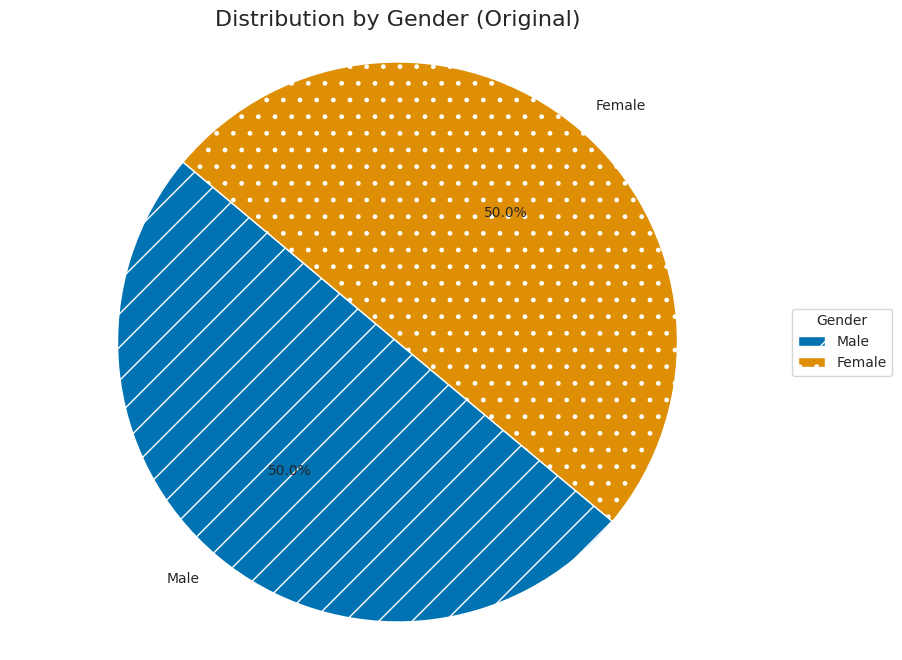

--- Alt Text for the Plot ---
A pie chart showing the gender distribution of the originaldataset, with male and female each consisits of 50% of the total population


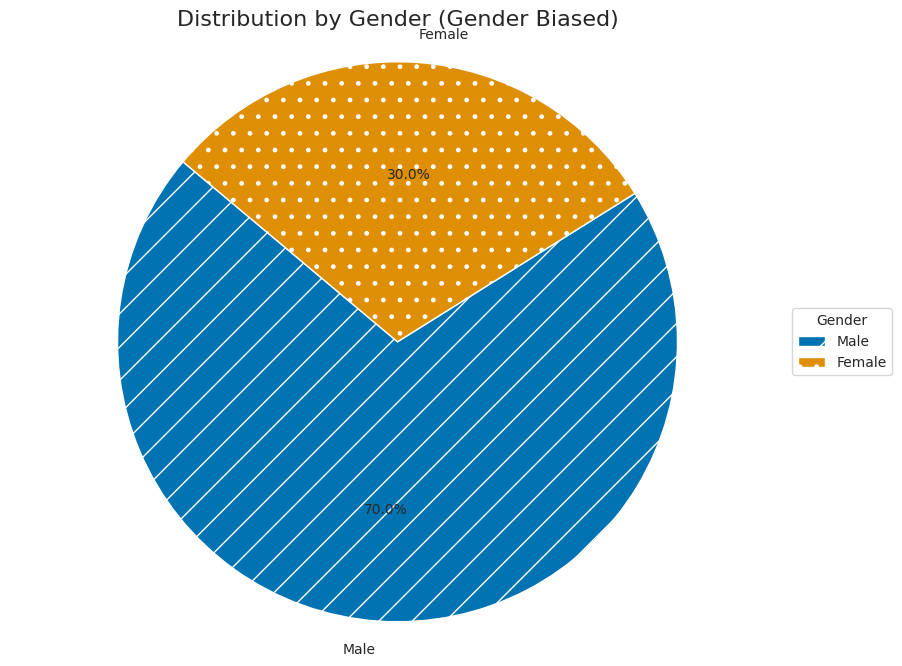

--- Alt Text for the Plot ---
A pie chart showing the gender distribution of the biased dataset. The distribution is 70% male and 30% female.


In [35]:
gender_counts = data['Gender'].value_counts()
gender_counts_biased = gender_bias_data['Gender'].value_counts()


# Accessibility Features
colors = sns.color_palette('colorblind', n_colors=2)
hatches = ['/', '.']

# Plot 1 (Original)
fig1, ax1 = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax1.pie(gender_counts,labels=gender_counts.index,autopct='%1.1f%%',startangle=140,colors=colors)#type:ignore
# Apply patterns
for i, wedge in enumerate(wedges):
    wedge.set_hatch(hatches[i])
ax1.set_title('Distribution by Gender (Original)', fontsize=16)
ax1.axis('equal')
ax1.legend(wedges, gender_counts.index, title="Gender", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart showing the gender distribution of the originaldataset, with male and female each consisits of 50% of the total population")


# Plot 2 (Gender Biased)
fig2, ax2 = plt.subplots(figsize=(10, 8))
wedges2, texts2, autotexts2 = ax2.pie(gender_counts_biased,labels=gender_counts_biased.index,autopct='%1.1f%%',startangle=140,colors=colors)#type:ignore
# Apply patterns
for i, wedge in enumerate(wedges2):
    wedge.set_hatch(hatches[i])
ax2.set_title('Distribution by Gender (Gender Biased)', fontsize=16)
ax2.axis('equal')
ax2.legend(wedges2, gender_counts_biased.index, title="Gender", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print("--- Alt Text for the Plot ---")
print("A pie chart showing the gender distribution of the biased dataset. The distribution is 70% male and 30% female.")


# Predictor Summary Statistics

In [36]:
#Table of predictor Summary Statistics

#For Continuous Variable Age
cont_summary = pd.DataFrame(columns = ['Predictor','Mean','Median','Standard Deviation','Min','Max'])
mean = np.mean(data['Age'])
median = np.median(data['Age'])
stand_dev = np.std(data['Age'])
min_val = np.min(data['Age'])
max_val = np.max(data['Age'])
cont_summary.loc[len(cont_summary)] = ['Age',mean,median,stand_dev,min_val,max_val]

#For Categorical Predictors: Race,Gender,Medical Condition
predictors = ['Race','Gender','Medical Condition']
cat_summary = pd.DataFrame(columns = ['Predictor','Mode','Frequency','Proportion','Levels'])
for predictor in predictors:
    mode = data[predictor].mode()
    freq = data[predictor].value_counts()
    prop = data[predictor].value_counts(normalize = True)
    levels= data[predictor].unique()
    cat_summary.loc[len(cat_summary)] = [predictor,mode,freq,prop,levels]

#Merging two summary tables
stat_summary = pd.merge(cont_summary,cat_summary,on = 'Predictor',how = 'outer')
stat_summary

stat_summary.fillna('Not Availiable')

,Predictor,Mean,Median,Standard Deviation,Min,Max,Mode,Frequency,Proportion,Levels
0,Age,51.539459,52.0,19.602277,13.0,89.0,Not Availiable,Not Availiable,Not Availiable,Not Availiable
1,Gender,Not Availiable,Not Availiable,Not Availiable,Not Availiable,Not Availiable,"0 Male Name: Gender, dtype: object",Gender Male 27774 Female 27726 Name: c...,Gender Male 0.500432 Female 0.499568 N...,"[Male, Female]"
2,Medical Condition,Not Availiable,Not Availiable,Not Availiable,Not Availiable,Not Availiable,"0 Arthritis Name: Medical Condition, dtype:...",Medical Condition Arthritis 9308 Diabete...,Medical Condition Arthritis 0.167712 Dia...,"[Cancer, Obesity, Diabetes, Asthma, Hypertensi..."
3,Race,Not Availiable,Not Availiable,Not Availiable,Not Availiable,Not Availiable,"0 White Name: Race, dtype: object",Race White 32768 Hispanic ...,Race White 0.590414 Hispanic ...,"[White, Hispanic, African American, Asian, Mul..."
